<a href="https://colab.research.google.com/github/Ningxiao-Tang/BankATM/blob/master/RedHat_NLP/Deliverable%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving logs - Sheet1.csv to logs - Sheet1 (3).csv
b'2020/09/02 22:13:39 ci-operator version v20200902-3839106\n2020/09/02 22:13:40 No source defined\n2020/09/02 22:13:40 Resolved release latest to registry.svc.ci.openshift.org/ocp/release:4.5-ci\n2020/09/02 22:13:40 Using namespace https://console.svc.ci.openshift.org/k8s/cluster/projects/ci-op-z4qkck75\n2020/09/02 22:13:40 Running [release-inputs], [images], [release:latest], e2e-aws\n2020/09/02 22:13:40 Creating namespace ci-op-z4qkck75\n2020/09/02 22:13:40 Setting up pipeline imagestream for the test\n2020/09/02 22:13:40 Created secret e2e-aws-cnv-cluster-profile\n2020/09/02 22:13:40 Created secret pull-secret\n2020/09/02 22:13:40 Created PDB for pods with openshift.io/build.name label\n2020/09/02 22:13:40 Created PDB for pods with created-by-ci label\n2020/09/02 22:13:40 Tagged shared images from ocp/4.5:${component}, images will be pullable from registry.svc.ci.openshift.org/ci-op-z4qkck75/stable:${component}\n2020/09/02 22:13:47 

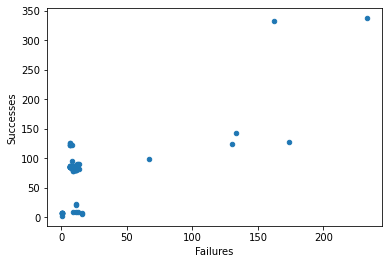

In [11]:
# Web scraping (Kyle, due 02/26/2021)
#     BeautifulSoup for web scraping

from urllib.request import urlopen
from bs4 import BeautifulSoup
from google.colab import files
import pandas as pd
import io
import numpy as np
import dateutil
from dateutil import parser
import textblob
from textblob import TextBlob
import nltk
from textblob import Word
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')

# upload file
uploaded = files.upload()
#read array
df2 = pd.read_csv(io.BytesIO(uploaded['logs - Sheet1.csv']))
#turn to flat list
array_pages = df2.to_numpy()
array_pages = np.ndarray.tolist(array_pages)
array_pages = [item for sublist in array_pages for item in sublist]
#url core needed to pull
base = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/canary-release-openshift-origin-installer-e2e-aws-4.5-cnv/"
ending = "build-log.txt"
url = "https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/canary-release-openshift-origin-installer-e2e-aws-4.5-cnv/1300557127638585344/build-log.txt"
# create array of urls
final_array = []
for x in range(len(array_pages)):
  final_array.append(base + array_pages[x] + ending)

# pull all urls logs and store in 2-d array where array_of_logs[x] is a build-log file and 
# array_of_logs[x][y] is an individual log line split by new line
array_of_logs = []
for x in range(len(final_array)):
  page = urlopen(final_array[x])
  html_bytes = page.read()
  array_of_logs.append(str(html_bytes))
  
# first log
print(array_of_logs[0])


# Analysis on the log data. Trying to find a framework. API (Ningxiao, Parker, Tianze, Hong)
#     Identify limitations with data and potential risks of achieving project goals.


# ******* PARKER *******
#  helper function detecting if a string is a date / timestamp
def is_date(str):
  try:
    dateutil.parser.parse(str)
    return True
  except:
    return False

# logs variable contains all parsed logs
logs = []
for i in range(len(array_of_logs)):
  #  removing newline characters
  array_of_logs[i] = array_of_logs[i].replace('\\n', ' ')
  array_of_logs[i] = array_of_logs[i].splitlines()

# removes leading 'b from log
  array_of_logs[i] = array_of_logs[i][0][2:]
# splitting each section as its own index (for parsing)
  array_of_logs[i] = array_of_logs[i].split(' ')

#  tmp is log without timestamps
  tmp = []
  for j in range(len(array_of_logs[i])):
    if is_date(array_of_logs[i][j]) == False:
      tmp.append(array_of_logs[i][j])
    else:
      continue
  logs.append(tmp)

# removes whitespace characters and keeps root words
stemmer = SnowballStemmer("english")
for log in logs:
  log[:] = [stemmer.stem(x) for x in log if x != '']

failures = []
successes = []
i = 0
for log in logs:
  tmp = ' '.join(log)
  tmp = TextBlob(tmp)
  sum_neg = tmp.word_counts['fail']
  sum_neg += tmp.word_counts['error']
  sum_pos = tmp.word_counts['success']
  sum_pos += tmp.word_counts['run']
  failures.append(sum_neg)
  successes.append(sum_pos)

plt.xlabel('Failures')
plt.ylabel('Successes')
plt.scatter(failures, successes, s=20)
plt.show()

# ******* PARKER *******

# ******* Tianze *******
#ignore useless "Waiting for setup to finish..."
def ignoreWaiting(logs):
  for i in range(len(logs)):
    if "Waiting for setup to finish..." in logs[i]:
      logs[i]=""
  return logs
# ******* Tianze *******


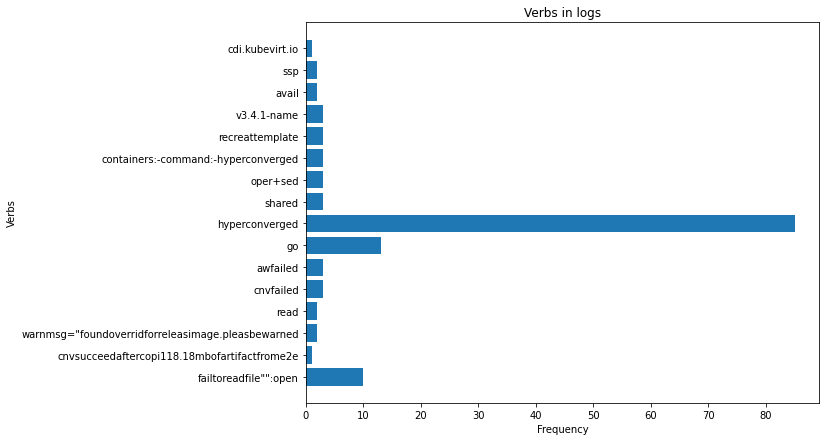

In [44]:
# ******* NINGXIAO *******
# find event in log, display frequecy of each event in a bar chart
import spacy
s = ""
for log in logs:
    temp = ""
    temp = temp.join(log)
    s += temp
# Error Message: Text of length 5496377 exceeds maximum of 1000000.
s = s[0:100000]
nlp = spacy.load("en_core_web_sm")
doc = nlp(s)
dictionary = {};
for token in doc:
    if token.pos_ == 'VERB':
        if token.text not in dictionary:
            dictionary[token.text] = 1
        else:
            dictionary[token.text] += 1
    #print(token.text, toekn.pos_)

#print(dictionary)

keys = list(dictionary.keys())
values = list(dictionary.values())

fig, ax = plt.subplots(figsize=(9.2, 7))  
ax.barh(keys,values)
plt.title('Verbs in logs')
plt.ylabel('Verbs')
plt.xlabel('Frequency')

plt.show()